# Running RAMP OpenCL model with dynamic calibration

### Parameter definitions
The OpenCL RAMP model creates a synthetic population and simulates the movements of individuals between various locations (home, work, school, shops). If an individual is infected then they impart an infection risk on to the locations that they visit. The severity of this infection risk is determined by whether the individual is presymptomatic, asymptomatic or symptomatic (the **individual's hazard rating**). The locations in the model thus come to have an infection risk, based upon how many infected individuals from each infection status have visited. When susceptible individuals without the disease visit these locations their risk of being infected is determined by the location's infection risk, alongside the transmission hazard associated with that kind of location (the location's hazard rating). An additional hazard rating, the current risk beta, is used to control the general transmissability of the disease (?) 

### Parameter calibration
The current risk beta parameter is calibrated in [this notebook](http://localhost:8888/notebooks/Users/gy17m2a/OneDrive%20-%20University%20of%20Leeds/Project/RAMP-UA/experiments/calibration/abc-2-NewObs.ipynb). This involves determining a prior distribution for both the current risk beta parameter, and for the individual and location hazard parameters. Approximate Bayesian Computation (ABC) is then used approximate the likelihood of different parameter values by running the model a large number of times. Each time parameter values are drawn randomly from the prior distributions, and the parameter values from the simulations with results closest to the observations are kept. A fitness function is used to assess the similarity of model results to observations. In this case, the Euclidean difference between the observed number of cases per week and the simulated number of cases per week is calculated. In this script, the model is ran using ABC for 105 days, with two populations. 

In this notebook, the current risk beta parameter value which was associated with the highest fitness in the final population in the calibration process above is set as a constant, and assumed not to change over the life of the disease. However, as the disease evolves, it is expected that the other parameters pertaining to the hazard associated with individuals and locations will change. If a model is calibrated just once using historical data then it will be unable to account for this parameter evolution. However, if it is dynamically calibrated, then it can be optimised in response to changes in parameter values in real time. Dynamic calibration involves re-calibrating the model at each time-step (e.g. after one day, one week etc), and using the best performing parameter value from the previous time-step for the next time-step. 

### Parameter priors
ABC requires prior distributions to be specified for the parameters.

<ins>Location hazards</ins> 
 - `Home` (transmission hazard associated with being with an infected individual at home)
     - <i>Fixed at 1.0, so all other multipliers are relative to this. This is almost certaintly the most risky activity (i.e. transmission at home is very likely) so no other priors allow values above 1.0. </i>
 - `Retail` (transmission hazard associated with being with an infected individual in a shop)
     - <i> Uniform between 0 and 1 </i>
 - `PrimarySchool` (transmission hazard associated with being with an infected individual at primary school)
     - <i> Uniform between 0 and 1 </i> 
 - `SecondarySchool` (transmission hazard associated with being with an infected individual at secondary school)
     - <i> Uniform between 0 and 1 </i> 
 - `Work` (transmission hazard associated with being with an infected individual at work)
     - <i> Uniform between 0 and 1 </i> 
 
<ins> Individual hazards</ins> 
 - `asymptomatic` (transmission hazard associated with asymptomatic individuals)  
      - <i> This is tricky because we don't know the hazard associated with asymptomatic transmission. James Salter used a prior of: N(0.444, 0.155) which gives the middle 95% as [0.138, 0.75] ([0.138 estimated here](https://www.medrxiv.org/content/10.1101/2020.06.04.20121434v2), [0.58 estimated here](https://jammi.utpjournals.press/doi/abs/10.3138/jammi-2020-0030), [0.75 estimated here (Table 1)](https://www.cdc.gov/coronavirus/2019-ncov/hcp/planning-scenarios.html). </i>
 - `presymptomatic` (transmission hazard associated with presymptomatic individuals)  
    - <i> Same as asymptomatic (but abc-2.iypnb fixes them at 1 ? </i>
 - `symptomatic` (transmission hazard associated with symptomatic individuals)   
    - <i> Same as asymptomatic (but abc-2.iypnb fixes them at 1 ?)</i>       

### Import modules

In [470]:
#### Import modules required
import multiprocessing as mp
import numpy as np
import os
import itertools
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import sys
import datetime
from matplotlib import cm

os.chdir("C:/Users/gy17m2a/OneDrive - University of Leeds/Project/RAMP-UA/experiments/calibration")

# PYABC (https://pyabc.readthedocs.io/en/latest/)
import pyabc
from pyabc.transition.multivariatenormal import MultivariateNormalTransition  # For drawing from the posterior
# Quieten down the pyopencl info messages (just print errors)
import logging

logging.getLogger("pyopencl").setLevel(logging.ERROR)

# Import arbitrary distribution class for using posterior estimates as new priors
sys.path.append('..')
from ArbitraryDistribution import ArbitraryDistribution

# RAMP model
from microsim.initialisation_cache import InitialisationCache
# from microsim.opencl.ramp.run import run_headless
# from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
# from microsim.opencl.ramp.snapshot import Snapshot
# from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
# from microsim.opencl.ramp.simulator import Simulator
# from microsim.opencl.ramp.disease_statuses import DiseaseStatus

# Bespoke RAMP classes for running the model
import sys

sys.path.append('..')
from opencl_runner import OpenCLWrapper  # Some additional functions to simplify running the OpenCL model
from opencl_runner import OpenCLRunner

# Set this to False to recalculate all results (good on HPC or whatever).
# If true then it loads pre-calculated results from pickle files (much quicker)
LOAD_PICKLES = True


#### Create observed cases data

In [257]:
# Observed cases data
cases_msoa_weekly = pd.read_csv("observation_data/weekly_cases_msoas_shifted_mpld_smoothed_IS.csv")
# remove date column
cases_msoa_weekly = cases_msoa_weekly.iloc[:, 1:]
# Transpose
cases_msoa_weekly = cases_msoa_weekly.T

# Observations are cases per msoa.
# Store as an array for us in model (more efficient?)
# (first axis is the msoa number, second is the day)
observations_weekly_array = cases_msoa_weekly.to_numpy()

## Get dataframe with totals for whole of Devon
cases_devon_weekly = pd.read_csv("observation_data/weekly_cases_devon_shifted_mpld_smoothed_IS.csv")
# Create new dataframe with cumulative sums rather than cases per day
cases_devon_weekly['CumulativeCases'] = cases_devon_weekly['OriginalCases'].cumsum()

# Read in daily devon case data (interpoalted from weekly)
cases_devon_daily = pd.read_csv("observation_data/daily_cases_devon_shifted_mpld_smoothed_IS.csv")
# Create new dataframe with cumulative sums rather than cases per day
cases_devon_daily['CumulativeCases'] = cases_devon_daily['OriginalCases'].cumsum()

# Read in daily msoa case data (interpoalted from weekly)
cases_msoa_daily = pd.read_csv("observation_data/daily_cases_msoas_shifted_mpld_smoothed_IS.csv")
#Create new dataframe with cumulative sums rather than cases per day
#cases_msoa_daily['CumulativeCases'] = cases_msoa_daily['OriginalCases'].cumsum()
# remove date column
cases_msoa_daily = cases_msoa_daily.iloc[:, 1:]
cases_msoa_daily = cases_msoa_daily.T
cases_msoa_daily.columns = range(1,(cases_msoa_daily.shape[1])+1)
cases_msoa_daily = cases_msoa_daily.add_prefix('Day')
cases_msoa_daily

,Day1,Day2,Day3,Day4,Day5,Day6,Day7,Day8,Day9,Day10,...,Day390,Day391,Day392,Day393,Day394,Day395,Day396,Day397,Day398,Day399
E02004140,2.078588e+01,2.081161e+01,2.081727e+01,2.076365e+01,2.058985e+01,2.022928e+01,1.965585e+01,1.897523e+01,1.843636e+01,1.808174e+01,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.218863e-07,8.694684e-07,8.859654e-07,5.999672e-07,2.311763e-07
E02004193,2.388616e+01,2.396584e+01,2.398891e+01,2.384311e+01,2.335188e+01,2.231812e+01,2.065520e+01,1.864907e+01,1.701594e+01,1.598969e+01,...,1.155716,1.013315,0.785343,0.505975,2.747531e-01,1.311680e-01,6.303259e-02,4.288829e-02,4.618269e-02,5.732854e-02
E02004204,1.145647e+01,1.152757e+01,1.154888e+01,1.142148e+01,1.098939e+01,1.007797e+01,8.609153e+00,6.832606e+00,5.380151e+00,4.474115e+00,...,0.000000,0.000000,0.000000,0.000000,7.215038e-07,1.199897e-06,1.022831e-06,6.347472e-07,2.331711e-07,0.000000e+00
E02004192,3.998320e+00,3.978869e+00,3.972155e+00,4.003767e+00,4.114463e+00,4.350565e+00,4.734358e+00,5.204135e+00,5.595808e+00,5.832255e+00,...,0.003902,0.003591,0.003082,0.002467,1.961004e-03,1.648485e-03,1.501154e-03,1.458400e-03,1.466507e-03,1.491577e-03
E02004160,8.746818e+00,8.659179e+00,8.631401e+00,8.782906e+00,9.302683e+00,1.040353e+01,1.218325e+01,1.434536e+01,1.612596e+01,1.722292e+01,...,0.004335,0.005050,0.006192,0.007592,8.750330e-03,9.470044e-03,9.811648e-03,9.912708e-03,9.896271e-03,9.840469e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E02004185,1.925084e-10,1.944129e-10,1.950131e-10,1.917076e-10,1.803818e-10,1.564054e-10,1.176566e-10,7.060507e-11,3.188301e-11,7.970498e-12,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,9.574770e-08,1.257883e-06,1.312832e-06,9.040388e-07,3.660621e-07
E02004212,1.637858e-10,1.654062e-10,1.659169e-10,1.631048e-10,1.534689e-10,1.330698e-10,1.001022e-10,6.007016e-11,2.712419e-11,6.777441e-12,...,0.004570,0.003959,0.003007,0.001823,8.344266e-04,2.165822e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
E02004228,3.062665e-10,3.092965e-10,3.102514e-10,3.049928e-10,2.869745e-10,2.488297e-10,1.871831e-10,1.123268e-10,5.072133e-11,1.267592e-11,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,8.571885e-05,7.026958e-04,7.209609e-04,4.906084e-04,1.918511e-04
E02004225,7.727859e-11,7.730403e-11,7.729160e-11,7.717232e-11,7.684686e-11,7.621949e-11,7.528343e-11,7.427797e-11,7.363073e-11,7.306397e-11,...,0.000415,0.001661,0.003677,0.006128,8.145751e-03,9.394471e-03,9.984333e-03,1.015649e-02,1.012524e-02,1.002605e-02


#### Setup Model
Optionally initialise the population, delete the old OpenCL model snapshot (i.e. an already-initialised model) and
re-create a new one. Useful if something may have changed (e.g. changed the lockdown file).


In [3]:
OPENCL_DIR = os.path.join("..", "..", "microsim", "opencl")
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

DATA_DIR = os.path.join("..", "..", "devon_data")
cache_dir = os.path.join(DATA_DIR, "caches")
cache = InitialisationCache(cache_dir=cache_dir)
if cache.is_empty():
    raise Exception(f"The cache in {cache_dir} has not been initialised. Probably need to run the code a",
                    "few cells up that initialises the population")

individuals_df, activity_locations = cache.read_from_cache()

print(f"Activity locations: {activity_locations}")


Activity locations: {'Home': <Home ActivityLocation>, 'Retail': <Retail ActivityLocation>, 'PrimarySchool': <PrimarySchool ActivityLocation>, 'SecondarySchool': <SecondarySchool ActivityLocation>, 'Work': <Work ActivityLocation>}


#### Define constants
These are not touched by ABC. Include parameters that should not be optimised.

In [4]:
const_params_dict = {
    "current_risk_beta": 0.025239665550846085,  # Global risk multplier (leave this as it is and allow the other parameters to vary)
    "home": 1.0, # Risk associated with being at home. Again leave this constant so the coefficients of other places will vary around it
}

#### Define random variables and the prior distributions
Random variables are the global parameters.

<IPython.core.display.Javascript object>


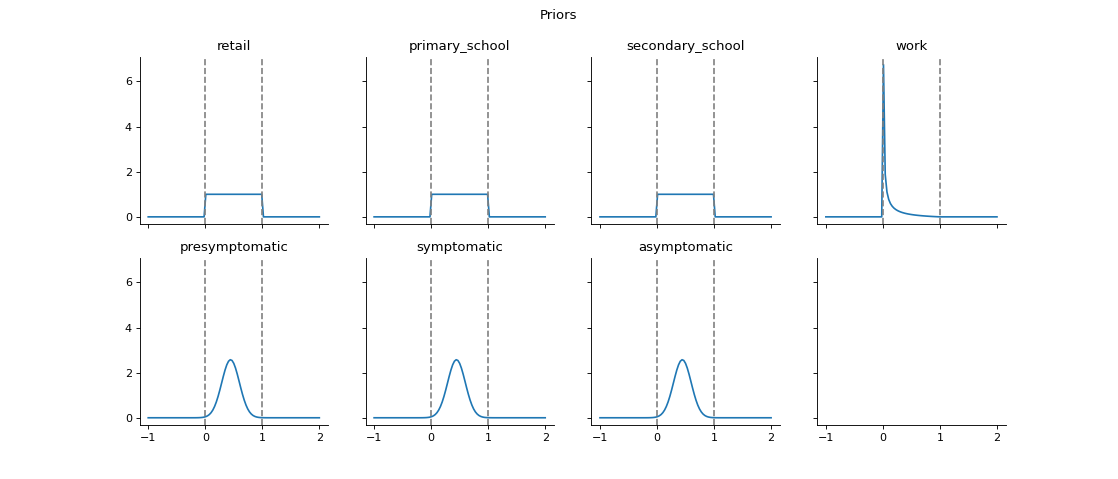

In [61]:
# School and retail multipliers are uniform between 0-1
retail_rv, primary_school_rv, secondary_school_rv = (pyabc.RV("uniform", 0, 1) for _ in range(3))
# Work needs some dampening because we know that workplaces are too big in the current implementation
work_rv = pyabc.RV("beta", 0.1, 2)

# Individual multipliers
# Asymptomatic is normal such that the middle 95% is the range [0.138, 0.75]  (see justification in abc)
# No idea about (pre)symptomatic, so use same distribution as asymptomatic
presymptomatic_rv, symptomatic_rv, asymptomatic_rv = (pyabc.RV("norm", 0.444, 0.155) for _ in range(3))

# Group all random variables together and give them a string name (this is needed for the distribution later)
all_rv = {
    "retail": retail_rv, "primary_school": primary_school_rv, "secondary_school": secondary_school_rv, "work": work_rv,
    "presymptomatic": presymptomatic_rv, "symptomatic": symptomatic_rv, "asymptomatic": asymptomatic_rv
}

# Plot priors
fig, axes = plt.subplots(2, 4, figsize=(14, 6), sharex=True, sharey=True)
x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
marker = itertools.cycle((',', '+', '.', 'o', '*'))
for i, (var_name, variable) in enumerate(all_rv.items()):
    # var_name = [ k for k,v in locals().items() if v is variable][0]  # Hack to get the name of the variable
    ax = axes.flatten()[i]
    # ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}), label = var_name, marker=next(marker), ms=3)
    ax.plot(x, pyabc.Distribution(param=variable).pdf({"param": x}))
    ax.set_title(var_name)
    ax.axvline(x=0.0, ls='--', color="grey", label="x=0")
    ax.axvline(x=1.0, ls='--', color="grey", label="x=1")
# fig.tight_layout()
fig.suptitle("Priors")
fig.show()

## Create a distrubtion from these random variables
decorated_rvs = {name: pyabc.LowerBoundDecorator(rv, 0.0) for name, rv in all_rv.items()}

# Define the original priors
original_priors = pyabc.Distribution(**decorated_rvs)

### Run model with dynamic calibration

#### Define parameters for running model

In [ ]:
# Path to parameters
parameters_file = os.path.join("../../", "model_parameters/",
                               "default.yml")  # Need to tell it where the default parameters are
# Set the size of a data assimilation window in days:
da_window_size = 14
# Dictionary with parameters for running model
admin_params = {"quiet": True, "use_gpu": True, "store_detailed_counts": True, "start_day": 0,
                "run_length": da_window_size,
                "current_particle_pop_df": None,
                "parameters_file": parameters_file, "snapshot_file": SNAPSHOT_FILEPATH, "opencl_dir": OPENCL_DIR,
                "individuals_df": individuals_df, "observations_weekly_array": observations_weekly_array,
                 'num_seed_days' :7}

#### Define dynamic calibration loop

In [6]:
# Create dictionaries to store the dfs, weights or history from each window (don't need all of these, but testing for now)
dfs_dict = {}
weights_dict = {}
history_dict = {}

# Store starting time to use to calculate how long processing the whole window has taken
starting_windows_time = datetime.datetime.now()

# Define number of windows to run for
windows = 2

# Loop through each window
for window_number in range(1, windows + 1):
    print("Window number: ", window_number)

    # Edit the da_window size in the admin params
    # print("Running for 14 days")
    admin_params['run_length'] = admin_params['run_length'] * window_number
    print("Running for {} days".format(da_window_size * window_number))

    # Create template for model
    template = OpenCLWrapper(const_params_dict, **admin_params)
    # Not sure why this is needed. Wthout it we get an error when passing the template object to ABCSMC below
    template.__name__ = OpenCLWrapper.__name__

    # Define priors
    # If first window, then use user-specified (original) priors
    if window_number == 1:
        # with open('abc-2_105days_7seeddays.pkl', 'rb') as f:
        #     old_history = pickle.load(f)
        # priors = ArbitraryDistribution(old_history)
        priors = original_priors
    # If a subsequent window, then generate distribution from posterior from previous window
    else:
        priors = ArbitraryDistribution(abc_history)

    # Set up model
    abc = pyabc.ABCSMC(
        models=template,  # Model (could be a list)
        parameter_priors=priors,  # Priors (could be a list)
        # summary_statistics=OpenCLWrapper.summary_stats,  # Summary statistics function (output passed to 'distance')
        distance_function=OpenCLWrapper.dummy_distance,  # Distance function
        sampler=pyabc.sampler.SingleCoreSampler()
        # Single core because the model is parallelised anyway (and easier to debug)
        # sampler=pyabc.sampler.MulticoreEvalParallelSampler()  # The default sampler
        #transition=transition,  # Define how to transition from one population to the next
    )

    # Prepare to run the model
    db_path = ("sqlite:///" + "ramp_da.db")  # Path to database

    # abc.new() needs the database location and any observations that we will use (these are passed to the
    # distance_function provided to pyabc.ABCSMC above). Currently the observations are provided to the model
    # when it is initialised and these are then used at the end of the model run() function. So they don't
    # need to be provided here.
    run_id = abc.new(
        db=db_path,
        observed_sum_stat=None  # {'observation': observations_array, "individuals": individuals_df}
    )

    # Run model
    abc_history = abc.run(max_nr_populations=2)

    # Save some info on the posterior parameter distributions.
    for t in range(0, abc.history.max_t + 1):
        print(t)
        # for this t (population) extract the 100 particle parameter values, and their weights
        df_t1, w_t1 = abc.history.get_distribution(m=0, t=t)

        # Save these for use in plotting the prior on the plot of parameter values in each population
        dfs_dict["w{},pop{}".format(window_number, t)] = df_t1
        weights_dict["w{}, pop{}".format(window_number, t)] = w_t1
        history_dict["w{}".format(window_number)] = abc_history


Window number:  1
Running for 14 days


c:\users\gy17m2a\onedrive - university of leeds\project\ramp-ua\microsim\opencl\ramp\params.py:58: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file. This warning will not be displayed again.
  warnings.warn("Params object is being created using hard-coded default values, "
ABC.History INFO: Start <ABCSMC id=59, start_time=2022-02-21 12:18:03>
ABC INFO: Calibration sample t = -1.


OpenclRunner ran model 1 in 0:00:02.891680
OpenclRunner ran model 2 in 0:00:02.356990
OpenclRunner ran model 3 in 0:00:02.438862
OpenclRunner ran model 4 in 0:00:02.374845
OpenclRunner ran model 5 in 0:00:02.679854
OpenclRunner ran model 6 in 0:00:02.346074
OpenclRunner ran model 7 in 0:00:02.679389
OpenclRunner ran model 8 in 0:00:02.395212
OpenclRunner ran model 9 in 0:00:02.495373
OpenclRunner ran model 10 in 0:00:02.220592
OpenclRunner ran model 11 in 0:00:02.395214
OpenclRunner ran model 12 in 0:00:02.628302
OpenclRunner ran model 13 in 0:00:02.333181
OpenclRunner ran model 14 in 0:00:02.643181
OpenclRunner ran model 15 in 0:00:02.405100
OpenclRunner ran model 16 in 0:00:02.595068
OpenclRunner ran model 17 in 0:00:02.378775
OpenclRunner ran model 18 in 0:00:02.542496
OpenclRunner ran model 19 in 0:00:02.286561
OpenclRunner ran model 20 in 0:00:02.416544
OpenclRunner ran model 21 in 0:00:02.591648
OpenclRunner ran model 22 in 0:00:02.353021
OpenclRunner ran model 23 in 0:00:02.7265

ABC INFO: t: 0, eps: 8.08388382e+03.


OpenclRunner ran model 101 in 0:00:02.217617
OpenclRunner ran model 102 in 0:00:02.520175
OpenclRunner ran model 103 in 0:00:02.366894
OpenclRunner ran model 104 in 0:00:02.625292
OpenclRunner ran model 105 in 0:00:02.286060
OpenclRunner ran model 106 in 0:00:01.904639
OpenclRunner ran model 107 in 0:00:01.727071
OpenclRunner ran model 108 in 0:00:02.207694
OpenclRunner ran model 109 in 0:00:01.929418
OpenclRunner ran model 110 in 0:00:02.437339
OpenclRunner ran model 111 in 0:00:02.650095
OpenclRunner ran model 112 in 0:00:02.291550
OpenclRunner ran model 113 in 0:00:02.673936
OpenclRunner ran model 114 in 0:00:02.340622
OpenclRunner ran model 115 in 0:00:02.528137
OpenclRunner ran model 116 in 0:00:02.285070
OpenclRunner ran model 117 in 0:00:02.327723
OpenclRunner ran model 118 in 0:00:02.261757
OpenclRunner ran model 119 in 0:00:02.471574
OpenclRunner ran model 120 in 0:00:02.707686
OpenclRunner ran model 121 in 0:00:02.314333
OpenclRunner ran model 122 in 0:00:02.672941
OpenclRunn

OpenclRunner ran model 284 in 0:00:02.190337
OpenclRunner ran model 285 in 0:00:02.286026
OpenclRunner ran model 286 in 0:00:02.506321
OpenclRunner ran model 287 in 0:00:02.255307
OpenclRunner ran model 288 in 0:00:02.659547
OpenclRunner ran model 289 in 0:00:02.263288
OpenclRunner ran model 290 in 0:00:02.483964
OpenclRunner ran model 291 in 0:00:02.235468
OpenclRunner ran model 292 in 0:00:02.379311
OpenclRunner ran model 293 in 0:00:02.294003
OpenclRunner ran model 294 in 0:00:02.464129
OpenclRunner ran model 295 in 0:00:02.499803
OpenclRunner ran model 296 in 0:00:02.263741
OpenclRunner ran model 297 in 0:00:02.600028
OpenclRunner ran model 298 in 0:00:02.223104
OpenclRunner ran model 299 in 0:00:02.470076
OpenclRunner ran model 300 in 0:00:02.190832
OpenclRunner ran model 301 in 0:00:02.396177
OpenclRunner ran model 302 in 0:00:02.469001
OpenclRunner ran model 303 in 0:00:02.191821
OpenclRunner ran model 304 in 0:00:02.500834
OpenclRunner ran model 305 in 0:00:02.236960
OpenclRunn

ABC INFO: Accepted: 100 / 211 = 4.7393e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 7.24238382e+03.


OpenclRunner ran model 312 in 0:00:02.141259
OpenclRunner ran model 313 in 0:00:02.349550
OpenclRunner ran model 314 in 0:00:02.180413
OpenclRunner ran model 315 in 0:00:02.381821
OpenclRunner ran model 316 in 0:00:02.490909
OpenclRunner ran model 317 in 0:00:02.294494
OpenclRunner ran model 318 in 0:00:02.517697
OpenclRunner ran model 319 in 0:00:02.232462
OpenclRunner ran model 320 in 0:00:02.477549
OpenclRunner ran model 321 in 0:00:02.218637
OpenclRunner ran model 322 in 0:00:02.446735
OpenclRunner ran model 323 in 0:00:02.289534
OpenclRunner ran model 324 in 0:00:02.345086
OpenclRunner ran model 325 in 0:00:02.502849
OpenclRunner ran model 326 in 0:00:02.229960
OpenclRunner ran model 327 in 0:00:02.501362
OpenclRunner ran model 328 in 0:00:02.212157
OpenclRunner ran model 329 in 0:00:02.435884
OpenclRunner ran model 330 in 0:00:02.187358
OpenclRunner ran model 331 in 0:00:02.377821
OpenclRunner ran model 332 in 0:00:02.214146
OpenclRunner ran model 333 in 0:00:02.390753
OpenclRunn

OpenclRunner ran model 495 in 0:00:02.278127
OpenclRunner ran model 496 in 0:00:02.476987
OpenclRunner ran model 497 in 0:00:02.358477
OpenclRunner ran model 498 in 0:00:02.513232
OpenclRunner ran model 499 in 0:00:02.203229
OpenclRunner ran model 500 in 0:00:02.549934
OpenclRunner ran model 501 in 0:00:02.246114
OpenclRunner ran model 502 in 0:00:02.528603
OpenclRunner ran model 503 in 0:00:02.189348
OpenclRunner ran model 504 in 0:00:02.315855
OpenclRunner ran model 505 in 0:00:02.476029
OpenclRunner ran model 506 in 0:00:02.239476
OpenclRunner ran model 507 in 0:00:02.492931
OpenclRunner ran model 508 in 0:00:02.197313
OpenclRunner ran model 509 in 0:00:02.843564
OpenclRunner ran model 510 in 0:00:02.581678
OpenclRunner ran model 511 in 0:00:02.329215
OpenclRunner ran model 512 in 0:00:02.556877
OpenclRunner ran model 513 in 0:00:02.220098
OpenclRunner ran model 514 in 0:00:02.590110
OpenclRunner ran model 515 in 0:00:02.244925
OpenclRunner ran model 516 in 0:00:02.519712
OpenclRunn

ABC INFO: Accepted: 100 / 209 = 4.7847e-01, ESS: 1.2176e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=59, duration=0:37:44.642324, end_time=2022-02-21 12:55:48>


0
1
Window number:  2
Running for 28 days


ABC.History INFO: Start <ABCSMC id=60, start_time=2022-02-21 12:55:48>
ABC INFO: Calibration sample t = -1.


Resampling
Resampling
Resampling
<Parameter 'asymptomatic': 0.321636295303798, 'presymptomatic': 0.33660071274008535, 'primary_school': 0.2488390448967168, 'retail': 0.7279943602199431, 'secondary_school': 0.43708507926085516, 'symptomatic': 0.4208423150914955, 'work': 0.013072742438407284>
OpenclRunner ran model 521 in 0:00:03.569212
Resampling
Resampling
<Parameter 'asymptomatic': 0.19033562824109163, 'presymptomatic': 0.4575554985039749, 'primary_school': 0.9903084409979381, 'retail': 0.5089568472036364, 'secondary_school': 0.5483864884684904, 'symptomatic': 0.5196152195728018, 'work': 0.017412842108037>
OpenclRunner ran model 522 in 0:00:04.222942
<Parameter 'asymptomatic': 0.18170377397612353, 'presymptomatic': 0.5263082270737365, 'primary_school': 1.3391943292445894, 'retail': 0.08333571668264225, 'secondary_school': 0.5490831111937886, 'symptomatic': 0.39062089711988707, 'work': 0.014165197999237256>
OpenclRunner ran model 523 in 0:00:03.618298
<Parameter 'asymptomatic': 0.17241

OpenclRunner ran model 547 in 0:00:03.096886
<Parameter 'asymptomatic': 0.3090275676752038, 'presymptomatic': 0.4102641547125865, 'primary_school': 0.5159528111017703, 'retail': 0.6336078492044548, 'secondary_school': 0.4494179880830086, 'symptomatic': 0.4720466590321676, 'work': 0.007732308838027746>
OpenclRunner ran model 548 in 0:00:03.225614
Resampling
<Parameter 'asymptomatic': 0.3174649459294078, 'presymptomatic': 0.391697478530315, 'primary_school': 0.18412519370472724, 'retail': 1.0952673158204154, 'secondary_school': 0.5219776417667826, 'symptomatic': 0.3089345822727206, 'work': 0.002565934257213646>
OpenclRunner ran model 549 in 0:00:03.264009
Resampling
Resampling
Resampling
Resampling
Resampling
Resampling
<Parameter 'asymptomatic': 0.32055093036801185, 'presymptomatic': 0.7654405437574816, 'primary_school': 0.8825681663046279, 'retail': 0.323908143998645, 'secondary_school': 0.6694298579140722, 'symptomatic': 0.08028983276862539, 'work': 0.005466846715747591>
OpenclRunner 

OpenclRunner ran model 573 in 0:00:03.173562
Resampling
Resampling
<Parameter 'asymptomatic': 0.43661000353937934, 'presymptomatic': 0.3795069573706798, 'primary_school': 0.08525057853697976, 'retail': 0.17459697325837167, 'secondary_school': 0.4860654811483973, 'symptomatic': 0.4568274064931355, 'work': 0.00575502119394243>
OpenclRunner ran model 574 in 0:00:03.186952
<Parameter 'asymptomatic': 0.23449702896980984, 'presymptomatic': 0.3051219311687451, 'primary_school': 0.19433767310750089, 'retail': 0.6390586711325855, 'secondary_school': 0.9182816505938188, 'symptomatic': 0.3223332186626324, 'work': 0.007436446161807303>
OpenclRunner ran model 575 in 0:00:03.203101
<Parameter 'asymptomatic': 0.20011372583456355, 'presymptomatic': 0.2539413712447917, 'primary_school': 0.06495069488287414, 'retail': 0.25251713971309425, 'secondary_school': 0.7544339340766507, 'symptomatic': 0.5180694842974757, 'work': 0.005359921179555888>
OpenclRunner ran model 576 in 0:00:03.179275
Resampling
Resamp

Resampling
Resampling
<Parameter 'asymptomatic': 0.3082146259505896, 'presymptomatic': 0.3329682005155557, 'primary_school': 0.2990687375460699, 'retail': 0.5089631021830172, 'secondary_school': 0.6914973692265773, 'symptomatic': 0.3056928512590502, 'work': 0.005065713125663167>
OpenclRunner ran model 600 in 0:00:03.237193
<Parameter 'asymptomatic': 0.23266088330495466, 'presymptomatic': 0.650928259559648, 'primary_school': 0.501388011877046, 'retail': 0.15545409013965705, 'secondary_school': 0.19498564921612443, 'symptomatic': 0.5788308947890574, 'work': 0.02069657173014264>
OpenclRunner ran model 601 in 0:00:03.161961
Resampling
Resampling
<Parameter 'asymptomatic': 0.2835298616659752, 'presymptomatic': 0.35923620853123034, 'primary_school': 0.3018037952727851, 'retail': 0.8333793154512855, 'secondary_school': 0.5147569805413804, 'symptomatic': 0.4251299043171099, 'work': 0.014302035130291577>
OpenclRunner ran model 602 in 0:00:03.173624
Resampling
Resampling
<Parameter 'asymptomatic

ABC INFO: t: 0, eps: 4.80007271e+04.


Resampling
<Parameter 'asymptomatic': 0.27118550833359656, 'presymptomatic': 0.20869227862572365, 'primary_school': 0.023998108201350288, 'retail': 0.8048030294991665, 'secondary_school': 0.12052195480350883, 'symptomatic': 0.5796162709360282, 'work': 0.0019599842165240224>
OpenclRunner ran model 621 in 0:00:03.072317
<Parameter 'asymptomatic': 0.26189679997514337, 'presymptomatic': 0.40247948371914594, 'primary_school': 0.935380099284715, 'retail': 0.2051000172175662, 'secondary_school': 0.4394233191636364, 'symptomatic': 0.2417936589129586, 'work': 0.009521265476352148>
OpenclRunner ran model 622 in 0:00:03.230160
Resampling
Resampling
Resampling
Resampling
Resampling
<Parameter 'asymptomatic': 0.31344205220061466, 'presymptomatic': 0.32373557771917993, 'primary_school': 0.5169441145720278, 'retail': 0.13728470592781356, 'secondary_school': 0.4973584487509424, 'symptomatic': 0.7194114201413337, 'work': 0.013965877725105862>
OpenclRunner ran model 623 in 0:00:03.173035
<Parameter 'asy

<Parameter 'asymptomatic': 0.052441036881121665, 'presymptomatic': 0.6134420598023527, 'primary_school': 0.5409977358994976, 'retail': 0.6397952792224191, 'secondary_school': 0.49354494465943105, 'symptomatic': 0.7900982056424717, 'work': 0.0758754617458472>
OpenclRunner ran model 647 in 0:00:03.187857
<Parameter 'asymptomatic': 0.11538462912892196, 'presymptomatic': 0.10380076743330668, 'primary_school': 0.898914634258264, 'retail': 0.6708060710769117, 'secondary_school': 0.6948086077084711, 'symptomatic': 0.6556367453696793, 'work': 0.02606449481648305>
OpenclRunner ran model 648 in 0:00:03.191230
<Parameter 'asymptomatic': 0.22219058383680815, 'presymptomatic': 0.5964567260191673, 'primary_school': 0.3151792989458872, 'retail': 0.2329468566430427, 'secondary_school': 0.536919576691891, 'symptomatic': 0.2595650971372687, 'work': 0.0018145255386359323>
OpenclRunner ran model 649 in 0:00:03.286504
<Parameter 'asymptomatic': 0.29772789309053405, 'presymptomatic': 0.42720472770437573, 'p

OpenclRunner ran model 673 in 0:00:03.196202
<Parameter 'asymptomatic': 0.40853470948464937, 'presymptomatic': 0.4212434815362476, 'primary_school': 0.1848141474733259, 'retail': 0.20920757739313245, 'secondary_school': 0.4077869601622732, 'symptomatic': 0.5305866549456074, 'work': 0.00927920538530694>
OpenclRunner ran model 674 in 0:00:03.201884
Resampling
<Parameter 'asymptomatic': 0.17988218079739157, 'presymptomatic': 0.3812071510135808, 'primary_school': 0.6734003989432851, 'retail': 0.16641742594617404, 'secondary_school': 0.7021316541375029, 'symptomatic': 0.472779018793077, 'work': 0.0016854779414016865>
OpenclRunner ran model 675 in 0:00:03.191817
<Parameter 'asymptomatic': 0.3222220615957463, 'presymptomatic': 0.7593628990788841, 'primary_school': 0.3092255343286365, 'retail': 0.16230162648687493, 'secondary_school': 0.5095759833748208, 'symptomatic': 0.5060266630415353, 'work': 0.012107990566655546>
OpenclRunner ran model 676 in 0:00:03.707752
Resampling
<Parameter 'asymptom

Resampling
Resampling
Resampling
<Parameter 'asymptomatic': 0.42220738188199514, 'presymptomatic': 0.5251222450894995, 'primary_school': 0.5279265207870775, 'retail': 0.2869339549928187, 'secondary_school': 0.6045141467840778, 'symptomatic': 0.27082456822832224, 'work': 0.012039662481387776>
OpenclRunner ran model 700 in 0:00:03.368232
<Parameter 'asymptomatic': 0.2930961313224141, 'presymptomatic': 0.38427604848308283, 'primary_school': 0.09148069759331562, 'retail': 0.3883622298015143, 'secondary_school': 0.5809219170007158, 'symptomatic': 0.36388299543847635, 'work': 0.002795779824376066>
OpenclRunner ran model 701 in 0:00:03.232512
<Parameter 'asymptomatic': 0.24324701976051416, 'presymptomatic': 0.21103081328836087, 'primary_school': 0.45478533829624485, 'retail': 0.6378515936237742, 'secondary_school': 0.5474902403531383, 'symptomatic': 0.46573630365073315, 'work': 0.010166749091150512>
OpenclRunner ran model 702 in 0:00:03.203245
Resampling
<Parameter 'asymptomatic': 0.217430315

OpenclRunner ran model 726 in 0:00:04.724925
<Parameter 'asymptomatic': 0.15099308206434484, 'presymptomatic': 0.44028347368967957, 'primary_school': 0.4528676852808261, 'retail': 0.2657833834523661, 'secondary_school': 0.6075801713237987, 'symptomatic': 0.27286822093822355, 'work': 0.009335889310653284>
OpenclRunner ran model 727 in 0:00:04.792376
Resampling
Resampling
<Parameter 'asymptomatic': 0.007406648615421951, 'presymptomatic': 0.9225145236482545, 'primary_school': 1.112403660075757, 'retail': 0.27869482433832493, 'secondary_school': 0.0018087044500750132, 'symptomatic': 0.15487599328774082, 'work': 0.001146676526381704>
OpenclRunner ran model 728 in 0:00:05.263047
Resampling
Resampling
Resampling
Resampling
<Parameter 'asymptomatic': 0.20874483599245994, 'presymptomatic': 0.2876370552687168, 'primary_school': 0.6556285544707994, 'retail': 1.0999748504486837, 'secondary_school': 0.7125631470881523, 'symptomatic': 0.45701601574181977, 'work': 0.01403302873290065>
OpenclRunner ra

OpenclRunner ran model 752 in 0:00:04.800287
<Parameter 'asymptomatic': 0.08520186316946851, 'presymptomatic': 0.4390999436614609, 'primary_school': 0.5100804853440426, 'retail': 0.6057561487057853, 'secondary_school': 0.38447179740797416, 'symptomatic': 0.5161357810819465, 'work': 0.00764997239702562>
OpenclRunner ran model 753 in 0:00:04.671289
<Parameter 'asymptomatic': 0.3390309073988213, 'presymptomatic': 0.6762434396805199, 'primary_school': 0.177568135453715, 'retail': 0.5655639918418581, 'secondary_school': 0.4113561448316334, 'symptomatic': 0.4866324759485251, 'work': 0.004072833360719604>
OpenclRunner ran model 754 in 0:00:04.725416
Resampling
<Parameter 'asymptomatic': 0.34291404887878657, 'presymptomatic': 0.06751911189998866, 'primary_school': 0.3029343308208163, 'retail': 0.6725611050121121, 'secondary_school': 0.5958748956529767, 'symptomatic': 0.04427740599641711, 'work': 0.008213551307595511>
OpenclRunner ran model 755 in 0:00:04.806196
Resampling
Resampling
<Parameter

OpenclRunner ran model 778 in 0:00:04.689676
Resampling
<Parameter 'asymptomatic': 0.28816693671536475, 'presymptomatic': 0.3861345832205193, 'primary_school': 1.2797314009484515, 'retail': 0.22672274184819413, 'secondary_school': 0.4540903584030131, 'symptomatic': 0.1627845217546808, 'work': 0.005959285834863371>
OpenclRunner ran model 779 in 0:00:04.703565
<Parameter 'asymptomatic': 0.2945080560741563, 'presymptomatic': 0.34613632828571117, 'primary_school': 0.49088267899079185, 'retail': 0.985440335233563, 'secondary_school': 0.127020801954427, 'symptomatic': 0.47046197251292204, 'work': 0.0003077282062628377>
OpenclRunner ran model 780 in 0:00:05.573547
<Parameter 'asymptomatic': 0.43516709138469867, 'presymptomatic': 0.5100109186726065, 'primary_school': 0.2087241192025938, 'retail': 0.0005221835477353942, 'secondary_school': 0.21253929074097494, 'symptomatic': 0.16359743388812106, 'work': 0.0024633894409488853>
OpenclRunner ran model 781 in 0:00:04.901478
<Parameter 'asymptomatic

OpenclRunner ran model 805 in 0:00:05.188603
<Parameter 'asymptomatic': 0.07775746786873373, 'presymptomatic': 0.5329109874413651, 'primary_school': 0.38199223624311424, 'retail': 0.2616061760049971, 'secondary_school': 0.5253064794148588, 'symptomatic': 0.12261436588323482, 'work': 0.0002443211936756973>
OpenclRunner ran model 806 in 0:00:06.055162
<Parameter 'asymptomatic': 0.1123433808661154, 'presymptomatic': 0.43437931278392106, 'primary_school': 0.5372176389405076, 'retail': 0.17426230900753292, 'secondary_school': 0.7690344768049812, 'symptomatic': 0.44378340149639095, 'work': 0.005094369650347005>
OpenclRunner ran model 807 in 0:00:05.935129
<Parameter 'asymptomatic': 0.26979724011617834, 'presymptomatic': 0.24272418725859693, 'primary_school': 1.2090985952782336, 'retail': 0.6589625389004973, 'secondary_school': 0.10547314383627662, 'symptomatic': 0.39532169026624625, 'work': 0.016094587359928036>
OpenclRunner ran model 808 in 0:00:05.575501
Resampling
<Parameter 'asymptomatic

ABC INFO: Accepted: 100 / 190 = 5.2632e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 2.83252271e+04.


OpenclRunner ran model 811 in 0:00:05.492199
OpenclRunner ran model 812 in 0:00:06.340337
OpenclRunner ran model 813 in 0:00:05.761037
OpenclRunner ran model 814 in 0:00:05.484796
OpenclRunner ran model 815 in 0:00:05.967869
OpenclRunner ran model 816 in 0:00:05.005657
OpenclRunner ran model 817 in 0:00:04.782958
OpenclRunner ran model 818 in 0:00:04.855836
OpenclRunner ran model 819 in 0:00:04.979340
OpenclRunner ran model 820 in 0:00:04.914399
OpenclRunner ran model 821 in 0:00:05.435693
OpenclRunner ran model 822 in 0:00:04.637592
OpenclRunner ran model 823 in 0:00:05.300142
OpenclRunner ran model 824 in 0:00:05.151943
OpenclRunner ran model 825 in 0:00:05.271980
OpenclRunner ran model 826 in 0:00:04.936242
OpenclRunner ran model 827 in 0:00:04.908375
OpenclRunner ran model 828 in 0:00:05.656874
OpenclRunner ran model 829 in 0:00:04.722411
OpenclRunner ran model 830 in 0:00:04.645534
OpenclRunner ran model 831 in 0:00:05.003150
OpenclRunner ran model 832 in 0:00:04.943608
OpenclRunn

OpenclRunner ran model 994 in 0:00:03.323230
OpenclRunner ran model 995 in 0:00:03.249813
OpenclRunner ran model 996 in 0:00:03.303614
OpenclRunner ran model 997 in 0:00:03.253260
OpenclRunner ran model 998 in 0:00:03.432209
OpenclRunner ran model 999 in 0:00:03.323438


ABC INFO: Accepted: 100 / 189 = 5.2910e-01, ESS: 6.6098e+00.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=60, duration=1:01:30.616483, end_time=2022-02-21 13:57:19>


0
1


#### Save abc_history object

In [11]:
# fname = "mollytest_2windows_7seeddays_olddist_rubbishresults.pkl"
# with open( fname, "wb" ) as f:
#         pickle.dump( abc_history, f)

### Compare model predictions from dynamically calibrated model against observations

#### Get model predictions, and particle distances for each particle in the final population 

In [385]:
# Create dictionary to store results for each window
abc_sum_stats = {}

# Loop through each calibration window, defining the number of days it covered
for window, n_days in { "w1": 14, "w2":28}.items():
    
    # Create lists to store values for each particle
    distance_l, daily_preds_l, params_l, daily_preds_msoa_l = [],[],[],[]
    
    # get the history for this window    
    history_wx  = history_dict[window]   
    
    # Get parameter values
    parameter_vals_df, w = history_wx.get_distribution(m=0, t=history_wx.max_t)

    # Get the summary stats for the final population for this window ([1] means keep just the 
    # dataframe and not the array of weights)
    weighted_sum_stats_t0 = history_wx.get_weighted_sum_stats_for_model(t=history_wx.max_t)[1]
    # Loop through each particle and save their distance and predictions into the lists
    for particle_no in range(0,100):
        # Get data for just this particle
        particle_x_dict = weighted_sum_stats_t0[particle_no]
        
        # Get daily predictions
        cumulative_model_diseased_by_area = particle_x_dict["cumulative_model_diseased_by_area"]     
        cumulative_model_diseased_by_area = cumulative_model_diseased_by_area.iloc[:,0:n_days]
        # Add daily msoa predictions for this particle to list
        daily_preds_msoa_l.append(cumulative_model_diseased_by_area)
        
        # Sum over Devon
        cumulative_model_diseased_by_area_devon_sum = cumulative_model_diseased_by_area.sum(axis=0)
    
        # Add daily predictions for this particle to list
        daily_preds_l.append(cumulative_model_diseased_by_area_devon_sum.values)
        
        # Add distance to list
        distance_l.append(particle_x_dict['distance'])
        
        # Add parameter values to list
        params_l.append(parameter_vals_df.iloc[particle_no])
        
    # Add to dictionary for this window
    abc_sum_stats[window] = {'distance_l':distance_l, 'daily_preds_ls' :daily_preds_l,
                             'params_ls':params_l, 'daily_preds_msoa_l' : daily_preds_msoa_l}

#### For each window, plot the number of infections predicted over time by each particle in the final population

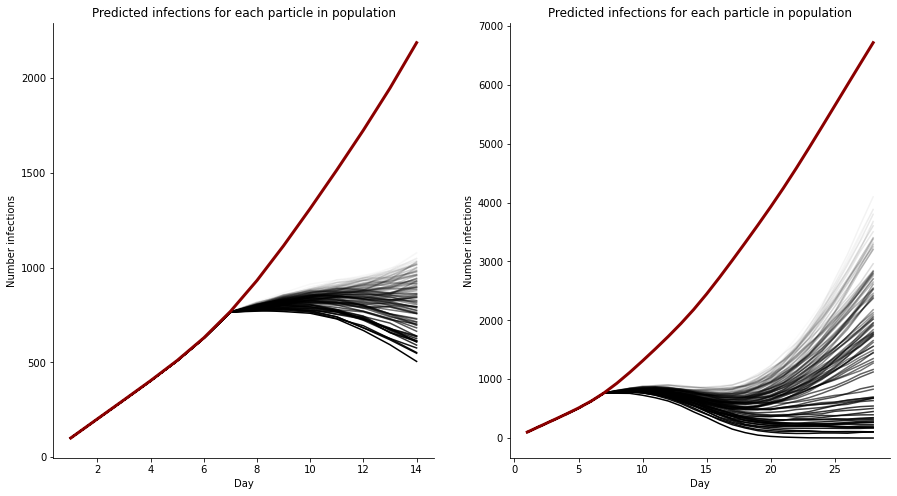

In [482]:
%matplotlib inline
# Create figure
fig, axes = plt.subplots(1, 2, figsize=(15,8))
axes_number = 0
for window, n_days in { "w1": 14, "w2":28}.items():
    # Get data for this window
    daily_preds_ls  = abc_sum_stats[window]['daily_preds_ls']   
    distance_l = abc_sum_stats[window]['distance_l']   

    # Normalise distance to 0-1 to calculate transparency
    _distance = np.array(distance_l)  # Easier to do maths on np.array
    distance_norm = (_distance - min(_distance)) / (max(_distance) - min(_distance))
    
    # define number of days these results relate to
    x=range(1,n_days+1)    
    
    # For each particle, plot the predictions, coloured by distance
    for i in range(0,len(daily_preds_l)):
        axes[axes_number].plot(x, daily_preds_ls[i],
                color="black", alpha=1-distance_norm[i])  # (1-x because high distance is bad)
   
    # Add observations
    axes[axes_number].plot(x, initial_cases['CumulativeCases'][0:len(daily_preds_ls[0])], label="Observations",
                           linewidth = 3, color="darkred")

    # Apply labels
    axes[axes_number].set_xlabel("Day")
    axes[axes_number].set_ylabel("Number infections")
    axes[axes_number].set_title("Predicted infections for each particle in population")
    
    axes_number =axes_number +1
    
best_particle_idx = abc_sum_stats[window]['distance_l'].index(min(abc_sum_stats[window]['distance_l']))
best_params =abc_sum_stats[window]['params_ls'][best_particle_idx]

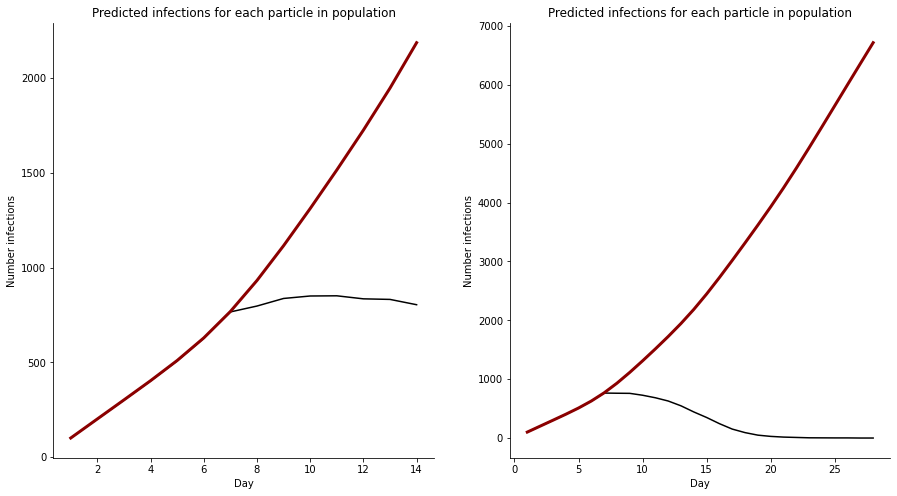

In [483]:
%matplotlib inline
# Create figure
fig, axes = plt.subplots(1, 2, figsize=(15,8))
axes_number = 0
for window, n_days in { "w1": 14, "w2":28}.items():
    # Get data for this window
    daily_preds_ls  = abc_sum_stats[window]['daily_preds_ls']   
    distance_l = abc_sum_stats[window]['distance_l']   

    # Normalise distance to 0-1 to calculate transparency
    _distance = np.array(distance_l)  # Easier to do maths on np.array
    distance_norm = (_distance - min(_distance)) / (max(_distance) - min(_distance))
    
    # define number of days these results relate to
    x=range(1,n_days+1)    
    
    axes[axes_number].plot(x, daily_preds_ls[best_particle_idx], color="black")  # (1-x because high distance is bad)
   
    # Add observations
    axes[axes_number].plot(x, initial_cases['CumulativeCases'][0:len(daily_preds_ls[0])], label="Observations",
                           linewidth = 3, color="darkred")

    # Apply labels
    axes[axes_number].set_xlabel("Day")
    axes[axes_number].set_ylabel("Number infections")
    axes[axes_number].set_title("Predicted infections for each particle in population")
    
    axes_number =axes_number +1
    
best_particle_idx = abc_sum_stats[window]['distance_l'].index(min(abc_sum_stats[window]['distance_l']))
best_params =abc_sum_stats[window]['params_ls'][best_particle_idx]

#### Plot spatial distribution of cases over time for best performing particle

In [83]:
## Load required spatial data
from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes
gis_data_dir = ("../../devon_data")
devon_msoa_shapes = load_msoa_shapes(gis_data_dir, visualize=False)    

### Load observations data
cases_msoa_daily['Code'] = cases_msoa_daily.index
cases_msoa_daily_shape = pd.merge(devon_msoa_shapes, cases_msoa_daily, on="Code")

### Load model data
daily_preds_msoa = daily_preds_msoa_l[best_particle_idx]
daily_preds_msoa['Code'] = daily_preds_msoa.index
daily_preds_msoa_shape = pd.merge(devon_msoa_shapes[['geometry', 'Code']], daily_preds_msoa, on="Code")

Loaded 7201 MSOA shapes with projection epsg:27700
Loaded 107 devon MSOA codes
Filtered 107 devon MSOA shapes


<IPython.core.display.Javascript object>


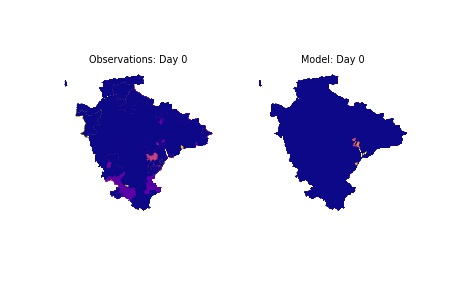

In [478]:
# Set up plotting
%matplotlib notebook
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
frames = daily_preds_msoa_shape.shape[1] -2
def animate(frame):
    cases_msoa_daily_shape.plot(column='Day' + str(frame+1), legend=False, ax=ax1)
    ax1.set_title('Observations: Day {}'.format(frame))
    ax1.axis('off')
    daily_preds_msoa_shape.plot(column='Day' + str(frame+1), legend=False, ax=ax2)
    ax2.set_title('Model: Day {}'.format(frame))
    ax2.axis('off')

def init():
    return animate(0)
       
# Not sure what, if anything, this does
from matplotlib import rc, animation
rc('animation', html='html5')
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
ani = matplotlib.animation.FuncAnimation(fig, animate, frames=frames, interval=200, save_count=50, blit=False,
                              init_func=init,repeat=True)
# from IPython.display import HTML
# HTML(ani.to_jshtml())

### Compare spatial distribution of total infections over final model window period across different particles 

<IPython.core.display.Javascript object>


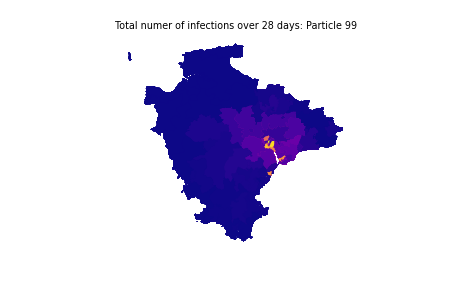

In [479]:
# Set up plotting
%matplotlib notebook

# Get statisitcis from final population of final window
weighted_sum_stats = abc_sum_stats['w2']

fig, ax = plt.subplots(figsize=(8,5))
frames = 100 #Number of frames
def draw(frame):
    # plt.clf()
    diseased_by_area =  weighted_sum_stats_t0[frame]['cumulative_model_diseased_by_area'].copy()
    # Add a column containing the cumulative total over all the days
    diseased_by_area['CumulativeTotal_model'] = diseased_by_area.sum(axis=1)
    diseased_by_area['Code'] = diseased_by_area.index
    diseased_by_area_shape = pd.merge(devon_msoa_shapes, diseased_by_area, on="Code")
    base = diseased_by_area_shape.plot(column="CumulativeTotal_model", legend=False, ax=ax)
    title = 'Total numer of infections over 28 days: Particle {}'.format(frame)
    plt.axis('off')
    plt.title(title)
    return base
    
def init():
    return draw(0)

def animate(frame):
    return draw(frame)

# Not sure what, if anything, this does
from matplotlib import rc, animation
rc('animation', html='html5')
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
ani = animation.FuncAnimation(fig, animate, frames, interval=200, save_count=50, blit=False, init_func=init,repeat=False)
# ani.save('basic_animation.gif', fps=1)

# from IPython.display import HTML
# HTML(ani.to_jshtml())


### Assess how parameter values change over time with dynamic calibration

#### Parameter values of final population for each window

C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


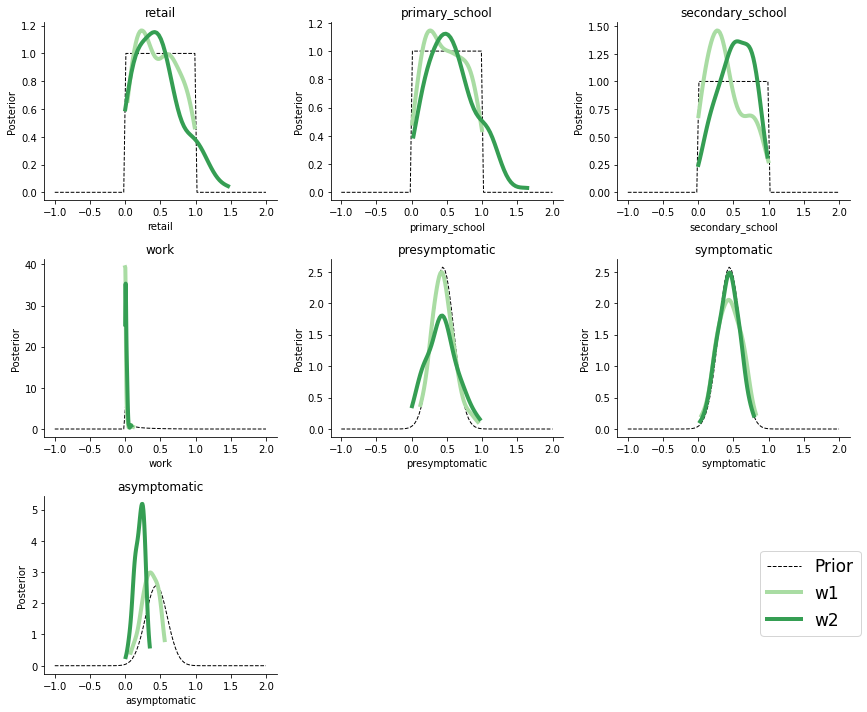

In [87]:
%matplotlib inline

# define colour map
evenly_spaced_interval = np.linspace(0.35, 1, 3)
colors = [cm.Greens(x) for x in evenly_spaced_interval]

fig, axes = plt.subplots(3,int(len(original_priors)/2), figsize=(12,10))
for i, param in enumerate(original_priors.keys()):
    color_i =0
    ax = axes.flat[i]
    # Add parameter priors
    priors_x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
    ax.plot(priors_x, pyabc.Distribution(param=all_rv[param]).pdf({"param": priors_x}), 
            color = 'black', label = 'Prior', linewidth  = 1, linestyle ='dashed')
    for history_name, history in history_dict.items():
        color = colors[color_i]
        df, w = history.get_distribution(m=0, t=0)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
                label=history_name, linewidth = 4,
                color= color)
        ax.legend(fontsize="small")
        ax.set_title(f"{param}")
        handles, labels = ax.get_legend_handles_labels()
        ax.get_legend().remove()
        color_i = color_i +1
fig.legend(handles, labels, loc='center right', fontsize = 17,
            bbox_to_anchor=(1.01, 0.17))
          # ncol = 8, bbox_to_anchor=(0.5, -0.07))
axes[2,2].set_axis_off()
axes[2,1].set_axis_off()
fig.tight_layout()
fig.show()
# fig.savefig("Plots/8windows_14days_each_finalpop.jpg")

#### Parameter values for all populations for each window

C:\ProgramData\Anaconda3\envs\newenv\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


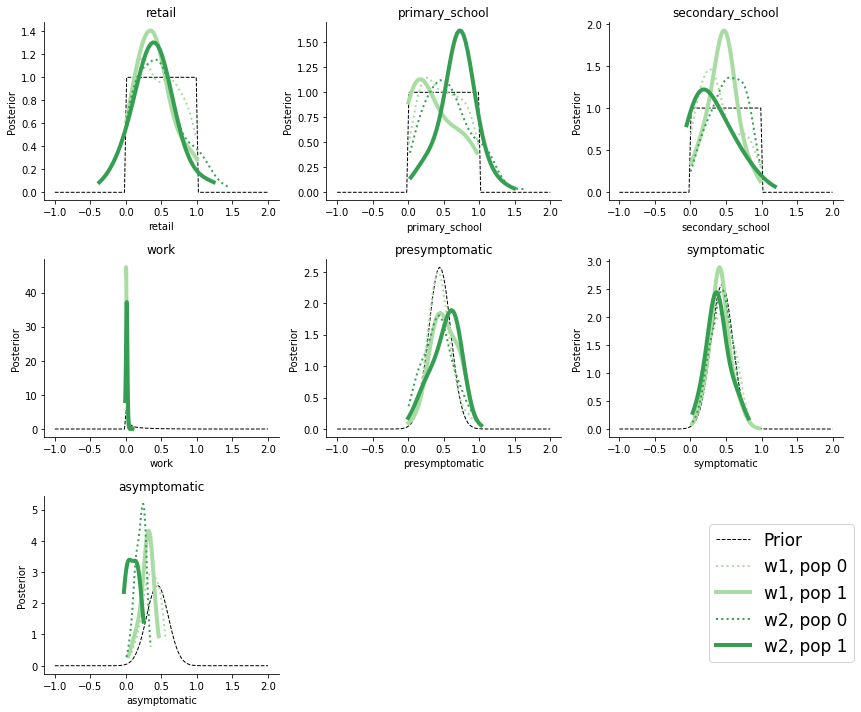

In [16]:
# define colour map and line style to use in intermediate populations
evenly_spaced_interval = np.linspace(0.35, 1, 3)
colors = [cm.Greens(x) for x in evenly_spaced_interval]
linestyles = ['dotted','solid'] # check this is same length as n populations
linewidths = [2,4]

# Set up plot
fig, axes = plt.subplots(3,int(len(original_priors)/2), figsize=(12,10))
for i, param in enumerate(original_priors.keys()):
    color_i =0
    ax = axes.flat[i]
    # Add parameter priors
    priors_x = np.linspace(-1, 2, 99)  # (specified so that we have some whole numbers)
    ax.plot(priors_x, pyabc.Distribution(param=all_rv[param]).pdf({"param": priors_x}), 
            color = 'black', label = 'Prior', linewidth  = 1, linestyle ='dashed')
    for history_name, history in history_dict.items():
        color = colors[color_i]
        for t in range(history.max_t + 1):
            df, w = history.get_distribution(m=0, t=t)
            pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
                label="{}, pop {}".format(history_name, t),
                color = color,
                linestyle = linestyles[t],linewidth = linewidths[t])
            ax.legend(fontsize="small")
            #ax.set_title(f"{param}: {posterior_df.loc[0,param]}")
            ax.set_title(f"{param}")
            handles, labels = ax.get_legend_handles_labels()
            ax.get_legend().remove()
        color_i = color_i +1
        
fig.legend(handles, labels, loc='center right', fontsize = 17,
            bbox_to_anchor=(1.01, 0.17))
          # ncol = 8, bbox_to_anchor=(0.5, -0.07))
axes[2,2].set_axis_off()
axes[2,1].set_axis_off()
fig.tight_layout()
fig.show()

### Run the model X (50?) times using parameter values drawn from the posterior
Plot the results to compare the performance of the model with the observations

In [472]:
## Define parameters
PARAMS = OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)
ITERATIONS = 105  # Number of iterations to run for
assert (ITERATIONS /7).is_integer() # check it is divisible by 7 
NUM_SEED_DAYS = 7  # Number of days to seed the population
USE_GPU = True
STORE_DETAILED_COUNTS = False
REPETITIONS = 5
USE_HEALTHIER_POP = True

# Initialise class so ready to run model
OpenCLRunner.init(iterations=ITERATIONS,
                  repetitions=REPETITIONS,
                  observations=cases_devon_weekly,
                  use_gpu=USE_GPU,
                  use_healthier_pop=USE_HEALTHIER_POP,
                  store_detailed_counts=STORE_DETAILED_COUNTS,
                  parameters_file=PARAMETERS_FILE,
                  opencl_dir=OPENCL_DIR,
                  snapshot_filepath=SNAPSHOT_FILEPATH,
                  num_seed_days = NUM_SEED_DAYS)

# Set constants 
OpenCLRunner.set_constants(const_params_dict)

# Define abc_history object from final window
abc_history = history_dict['w2']

# Define the number of samples to take from the posterior distribution of parameters
N_samples = 10

# Get dataframe of posterior parameter values
df, w = abc_history.get_distribution(m=0, t=abc_history.max_t)

# Sample from the dataframe of posteriors using KDE
kde = MultivariateNormalTransition(scaling=1)
kde.fit(df, w)
samples = kde.rvs(N_samples)

# Now run N models and store the results of each one
distance_l, sim_l, obs_l, out_params_l,out_calibrated_params_l, summaries_l = [],[],[],[],[],[] 

negative_count = 0  # Count the number of negatives returned in the KDE posterior
for i, sample in samples.iterrows():
    # Check for negatives. If needed, resample
    while (sample < 0).values.any():
        print("Found negatives. Resampling")
        negative_count += 1
        sample = kde.rvs()
        # Added in this line as the sample was in the wrong format for the while loop
        sample = pd.Series(sample)

    # Create a dictionary with the parameters and their values for this sample
    param_values = sample.to_dict()
    print(param_values)

    # _summaries = 
    (_distance, _sim, _obs, _out_params, _summaries) = \
        OpenCLRunner.run_model_with_params_abc(param_values, return_full_details=True)
    print(f"distance: {_distance}.")

    distance_l.append(_distance)
    sim_l.append(_sim)
    obs_l.append(_obs)
    out_params_l.append(_out_params)
    out_calibrated_params_l.append(param_values)
    summaries_l.append(_summaries)

print(f"Finished sampling. Ignored {negative_count} negative samples.")

{'asymptomatic': 0.1180675624612636, 'presymptomatic': 0.8442863186496824, 'primary_school': 0.8790432330941375, 'retail': 0.400795865596492, 'secondary_school': 0.8370440440639478, 'symptomatic': 0.40981460483925747, 'work': 0.003302162760975603}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.06s/it]


distance: 23818.95572902871.
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.01640105676451377, 'presymptomatic': 0.5146246386711354, 'primary_school': 0.8009749772496028, 'retail': 0.25011631744730617, 'secondary_school': 0.2584324739319748, 'symptomatic': 0.5581231624669123, 'work': 0.01799004611544813}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.99s/it]


distance: 42380.02345605627.
Found negatives. Resampling
{'asymptomatic': 0.18556463540622414, 'presymptomatic': 0.26853059901605186, 'primary_school': 0.6604516964858089, 'retail': 0.26657512212394086, 'secondary_school': 0.5787899066195128, 'symptomatic': 0.27161880046612014, 'work': 0.03600652453110412}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.89s/it]


distance: 24676.722063239868.
Found negatives. Resampling
{'asymptomatic': 0.12295152715187425, 'presymptomatic': 0.4476736648137119, 'primary_school': 0.43538851775249904, 'retail': 0.47638402563050364, 'secondary_school': 0.5554452044069778, 'symptomatic': 0.4849245085912193, 'work': 0.00686036396588147}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.93s/it]


distance: 32515.93576595288.
{'asymptomatic': 0.26022024254071313, 'presymptomatic': 0.2853670635810463, 'primary_school': 0.8323510830311883, 'retail': 0.4756294674300875, 'secondary_school': 0.6406671789993723, 'symptomatic': 0.5707119946389091, 'work': 0.01129781359513228}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.89s/it]


distance: 5026.377762572465.
{'asymptomatic': 0.11982690667127698, 'presymptomatic': 0.2464477000186596, 'primary_school': 0.7137284422561522, 'retail': 1.1153689890816834, 'secondary_school': 0.6478521475151156, 'symptomatic': 0.22750260451695725, 'work': 0.008525804822431454}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.95s/it]


distance: 36002.45837396412.
{'asymptomatic': 0.10688864627564798, 'presymptomatic': 0.42645138723629905, 'primary_school': 0.7418304257664377, 'retail': 0.1855225812019451, 'secondary_school': 0.44900448945534793, 'symptomatic': 0.4256625078566995, 'work': 0.012996622990489442}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.99s/it]


distance: 36546.48227016483.
Found negatives. Resampling
Found negatives. Resampling
{'asymptomatic': 0.2366593960353855, 'presymptomatic': 0.3922106232432918, 'primary_school': 0.48518953880583604, 'retail': 0.48643706916267315, 'secondary_school': 0.37762198843019457, 'symptomatic': 0.4557472082899703, 'work': 0.024867573534178712}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.97s/it]


distance: 13214.64331507162.
{'asymptomatic': 0.09388490799069867, 'presymptomatic': 0.6101251518288084, 'primary_school': 0.95616102706102, 'retail': 0.08859257391378494, 'secondary_school': 0.24567644169390362, 'symptomatic': 0.18226583758412618, 'work': 0.011195862604509896}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:39<00:00,  7.94s/it]


distance: 37196.83297583191.
{'asymptomatic': 0.21751802108174195, 'presymptomatic': 0.8879423879753869, 'primary_school': 0.6437881408903412, 'retail': 0.11696866817375777, 'secondary_school': 0.7050977429109572, 'symptomatic': 0.36475524343520144, 'work': 0.017298759902892143}


Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.00s/it]

distance: 5487.374764477181.
Finished sampling. Ignored 6 negative samples.


#### Plot the individual results for each sample and compare to observations

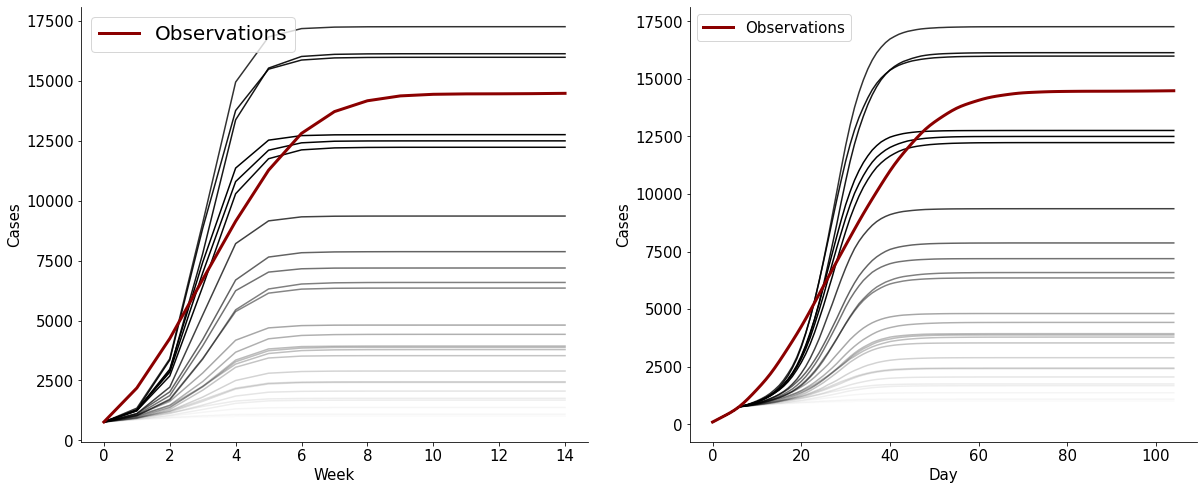

In [14]:
# Read in initial cases data (ued in seeding)
initial_cases = pd.read_csv("../../microsim/opencl/data/daily_cases_devon_shifted_mpld_smoothed_IS.csv")
initial_cases['CumulativeCases'] = initial_cases['num_cases'].cumsum()
initial_cases_weekly = pd.DataFrame({'OriginalCases':
                                    initial_cases['num_cases'].groupby(initial_cases['num_cases'].index // 7).sum()})
initial_cases_weekly['CumulativeCases'] = initial_cases_weekly.cumsum()

# Normalise distance to 0-1 to calculate transparency
_distance = np.array(distance_l)  # Easier to do maths on np.array
distance_norm = (_distance - min(_distance)) / (max(_distance) - min(_distance))

############## PLOT WEEKLY DATA
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
x = range(len(sim_l[0]))
for i in range(len(summaries_l)):
    ax1.plot(x, sim_l[i],
            color="black", alpha=1 - distance_norm[i]) # (1-x because high distance is bad)
# Plot observations
ax1.plot(x, initial_cases_weekly['CumulativeCases'][0:int((105/7))], label="Observations", linewidth=3, color="darkred")
# Plot result from manually calibrated model
ax1.legend(fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.set_xlabel("Week", size=15)
ax1.set_ylabel("Cases",size=15)

############## PLOT DAILY DATA
x = range(len(OpenCLRunner.get_cumulative_new_infections(summaries_l[1])))
for i in range(len(summaries_l)):
    ax2.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries_l[i]),
            # label=f"Particle {df.index[sample_idx[i]]}",
            color="black", alpha=1 - distance_norm[i]  # (1-x because high distance is bad)
            )
# Plot observations
ax2.plot(x, initial_cases['CumulativeCases'][0:105], label="Observations", linewidth = 3, color="darkred")
# Plot result from manually calibrated model
# ax2.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim", color="orange")
# Format
ax2.legend(fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_xlabel("Day", size=15)
ax2.set_ylabel("Cases",size=15)

del _distance, distance_norm


### Run model with single 'best' estimate of parameter values 

#### Find the sample drawn from the posterior distribution which has the smallest distance (best performing!)

In [17]:
# Find the index of the lowest distance value
best_model_idx = np.argmin(distance_l)
# Find the corresponding parameter values
best_params = out_calibrated_params_l[best_model_idx]
# Sanity check, the calibrated param should be the same as the one in the params object
assert np.isclose(out_calibrated_params_l[best_model_idx]['asymptomatic'],
                  out_params_l[best_model_idx].individual_hazard_multipliers[1])
print(best_params)

{'asymptomatic': 0.26993668936531556, 'presymptomatic': 0.21920841320092105, 'primary_school': 0.7249504059136043, 'retail': 0.1486254553079925, 'secondary_school': 0.6642627351780961, 'symptomatic': 0.25771605755591454, 'work': 0.03284448802312134}


#### See how the parameters from the particle with the lowest distance relate to the marginal posteriors

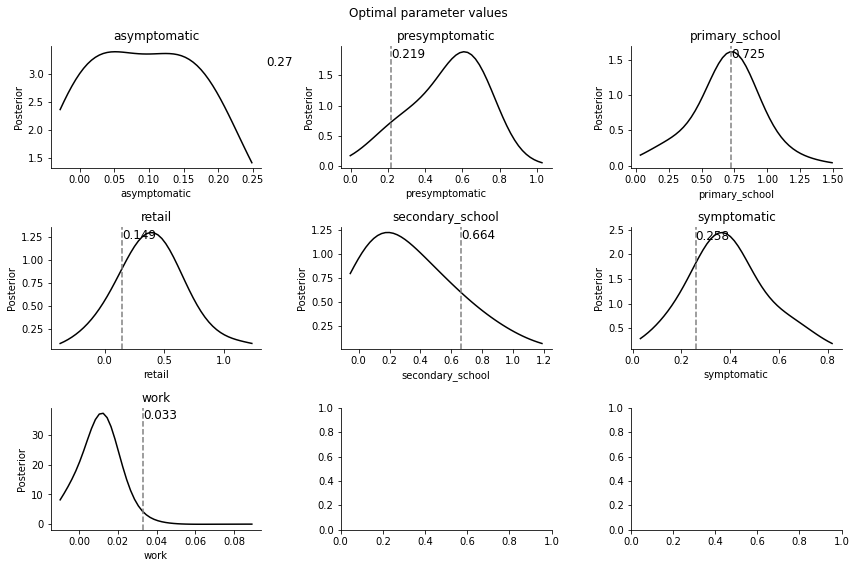

In [89]:
fig, axes = plt.subplots(3,3, figsize=(12,8))
abc_history = history_dict['w2']
for i, param in enumerate(best_params.keys()):
    ax = axes.flat[i]
    df, w = abc_history.get_distribution(m=0, t=abc_history.max_t)
    pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax,
            label=f"{param} PDF t={t}",
            alpha=1.0 if t==0 else float(t)/abc_history.max_t, # Make earlier populations transparent
            color= "black" if t==history.max_t else None) # Make the last one black
    ax.axvline(x=best_params[param], color="grey", linestyle="dashed")
    ax.text(x=best_params[param], y=0.9*ax.get_ylim()[1], s=str(round(best_params[param],3)), fontsize=12)
    ax.set_title(f"{param}")
fig.suptitle("Optimal parameter values")
fig.tight_layout()

#### Run model with 'best' parameter values

In [19]:
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(distance_bestparams, sim_bestparams, obs_bestparams, out_params_bestparams, summaries_bestparams) = OpenCLRunner.run_model_with_params_abc(
    best_params, return_full_details=True)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:50<00:00, 22.01s/it]


In [ ]:
# ### Initialise the ABC algorithm.
abc = pyabc.ABCSMC(
    models=OpenCLRunner.run_model_with_params_abc, # Model (could be a list)
    parameter_priors=priors, # Priors (could be a list)
    distance_function=distance,  # Distance function
    # distance_function = OpenCLWrapper.distance,
    sampler = pyabc.sampler.SingleCoreSampler()  # Single core because the model is parallelised
    #transition=transition,  # Define how to transition from one population to the next
    )

#### Run model with uncalibrated parameter values for comparison

In [106]:
OpenCLRunner.update(repetitions=5)  # Temporarily use more repetitions to give a good baseline
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(distance_manualcalibration, sim_manualcalibration, obs_manualcalibration, out_params_manualcalibration, summaries_manualcalibration) = OpenCLRunner.run_model_with_params_abc({}, return_full_details=True)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)    

Running models: 100%|████████████████████████████████████████████████████████████████████| 5/5 [01:53<00:00, 22.64s/it]


#### Plot results

distance: 42141.954464816605


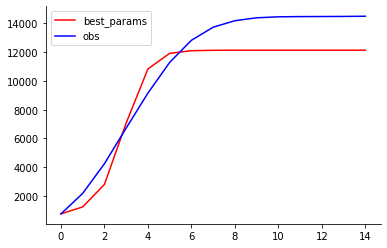

In [111]:
# Check the model returns the observations correctly (should be same as initial, default model)
# np.array_equal(obs0, obs1)
fig, ax = plt.subplots(1,1)
x = range(len(sim_bestparams))
ax.plot(x, sim_bestparams, label="best_params", color="red")
# ax.plot(x, sim_manualcalibration, label="manual_calibration", color="green")
# Add distance text
# for a, b in [(summaries_manualcalibration,distance_manualcalibration), (summaries_bestparams, distance_bestparams)]:
#     ax.text(x=len(x), y=max(OpenCLRunner.get_cumulative_new_infections(a)), s=f"Fit: {round(b)}", fontsize=10)
ax.plot(x, initial_cases_weekly['CumulativeCases'][0:(int(ITERATIONS/7))], label="obs", color="blue")
ax.legend()
print(f"distance: {distance_bestparams2}")

Text(0, 0.5, 'Cases')

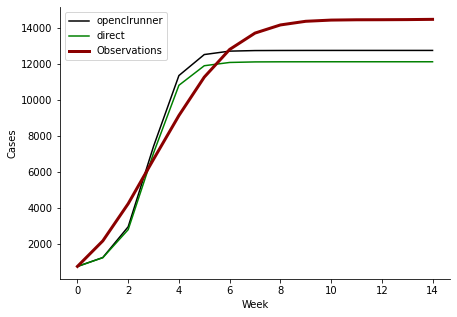

In [135]:
fig, ax = plt.subplots(figsize = (7,5))
x = range(len(sim_l[0]))
ax.plot(x, sim_l[best_model_idx],color="black", label = 'openclrunner') # (1-x because high distance is bad)
ax.plot(x, sim_bestparams, label="direct", color="green")
# Plot observations
ax.plot(x, initial_cases_weekly['CumulativeCases'][0:int((105/7))], label="Observations", linewidth=3, color="darkred")

# Plot result from manually calibrated model
ax.legend(fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlabel("Week", size=10)
ax.set_ylabel("Cases",size=10)

### Compare spatial distribution

Can't do this currently as OpenCLRunner doesn't return a breakdown by MSOA

### Save/pickle

In [41]:
fname = "2windows_7seeds_OldDistance_abc.pkl"
with open( fname, "wb" ) as f:
        pickle.dump( history, f)